In [21]:
import nyisotoolkit
from nyisotoolkit import NYISOData, NYISOStat,NYISOVis
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error,r2_score
import matplotlib.pyplot as plt
from meteostat import Hourly, Point
from datetime import datetime
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

I used the NYISO API and got load and marginal cost data from the years 2022 and 2023. Then, I did the same using Meteostats' API. I found it to be easier to clean the data in R and then import back to Python. As I'm not sure how to use both languages together in the same notebook, I may release the work that I did in R separately.

In [3]:
df = pd.read_csv("C:/Users/Khalil/Downloads/merged_data.csv")

#Change column type to datetime64[ns] for column: 'date_time'
df = df.astype({'date_time': 'datetime64[ns]'})



In [4]:
#I'm assuming that a precipitation value of "NA" accounts for days where there was no precipitation.
df["prcp"] = df["prcp"].fillna(0)

#I will also assume that the wind directions that are missing are southbound winds from the north, especially
#since such rows always seem to have a wind speed value
df["wdir"] = df["wdir"].fillna(0)


# Drop column: 'tsun'
df = df.drop(columns=['tsun'])

# Change column type to category for column: 'coco'
df = df.astype({'coco': 'category'})

# Rename column 'LBMP....MWHr..N.Y.C.' to 'Price(MWhr)'
df = df.rename(columns={'LBMP....MWHr..N.Y.C.': 'Price(MWhr)'})

# Rename column 'Marginal.Cost.Losses....MWHr..N.Y.C.' to 'Marginal_Cost_Losses(MWHr)'
df = df.rename(columns={'Marginal.Cost.Losses....MWHr..N.Y.C.': 'Marginal_Cost_Losses(MWHr)'})

# Rename column 'Marginal.Cost.Congestion....MWHr..N.Y.C.' to 'Marginal_Cost_Congestion(MWHr)'
df = df.rename(columns={'Marginal.Cost.Congestion....MWHr..N.Y.C.': 'Marginal_Cost_Congestion(MWHr)'})

# Rename column 'N.Y.C.' to 'Load'
df = df.rename(columns={'N.Y.C.': 'Load'})

For the weather condition code, less than 1% of the rows have missing values. The dictionary that the dataset
came with explains that some weather stations either don't report weather conditions unless they are significant
or they just don't report them at all. Ordinarily, I would use something like missForest for imputation or some other more sophisticated method but that's overkill for such a small proportion of missing data. It would be better to just use the mode of the column instead of just deleting them to retain as much data as possible.



In [5]:
from sklearn.impute import SimpleImputer

# Impute with the most frequent value
imputer = SimpleImputer(strategy='most_frequent')
df['coco'] = imputer.fit_transform(df[['coco']])


In [6]:

# Extract components from the date_time column
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['hour'] = df['date_time'].dt.hour
df['minute'] = df['date_time'].dt.minute
df['second'] = df['date_time'].dt.second
df['day_of_week'] = df['date_time'].dt.dayofweek  # Monday=0, Sunday=6
df['day_of_year'] = df['date_time'].dt.dayofyear
df['week_of_year'] = df['date_time'].dt.isocalendar().week

# Display the DataFrame with new features
print(df.head())

            date_time  Price(MWhr)  Marginal_Cost_Losses(MWHr)  \
0 2022-01-01 05:00:00        30.95                        2.49   
1 2022-01-01 06:00:00        28.25                        2.14   
2 2022-01-01 07:00:00        26.31                        1.90   
3 2022-01-01 08:00:00        25.29                        1.76   
4 2022-01-01 09:00:00        25.24                        1.62   

   Marginal_Cost_Congestion(MWHr)       Load  temp  dwpt  rhum  prcp  wdir  \
0                           -2.01  4551.6874   7.2   6.9    98   0.0   192   
1                           -2.30  4341.7987   6.5   6.4    99   0.0   144   
2                           -3.48  4193.6776   6.4   6.3    99   0.0   166   
3                           -4.42  4087.6516   8.2   8.1    99   0.0   137   
4                           -5.97  4016.1398   8.4   8.3    99   0.0   139   

   ...  coco  year  month  day  hour  minute  second  day_of_week  \
0  ...   5.0  2022      1    1     5       0       0            5

Since we have two years worth of data, let's use one to train our model(s) and the other to test its performance.

In [7]:
import pandas as pd


# Define the split date
split_date = '2023-01-01 05:00:00'


# Split the DataFrame into training and testing sets based on the split date
train_data = df[df['date_time'] < split_date]
test_data = df[df['date_time'] >= split_date]



In [8]:


# Separate the features and response for training and testing sets
response_var = "Price(MWhr)"

X_train = train_data.drop(columns=[response_var,"date_time"])
y_train = train_data[response_var]
X_test = test_data.drop(columns=[response_var,"date_time"])
y_test = test_data[response_var]





print("Training set size:", len(X_train))
print("Testing set size:", len(X_test))


Training set size: 8760
Testing set size: 8732


Random Forest Creation/Validation

Random Forest RMSE: 13.963765820782253
Random Forest R-squared: 0.4730597132599208


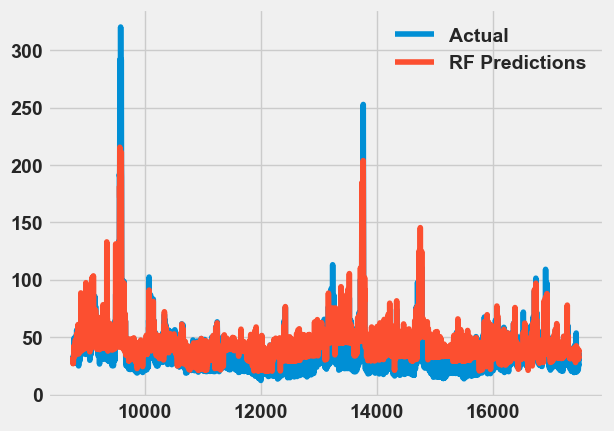

In [9]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)


# Evaluate
rf_rmse = root_mean_squared_error(y_test, rf_pred)
print(f'Random Forest RMSE: {rf_rmse}')

r_squared_forest = r2_score(y_test, rf_pred)
print(f'Random Forest R-squared: {r_squared_forest}')

# Plot predictions
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_pred, label='RF Predictions')
plt.legend()
plt.show() 

ARIMA Model


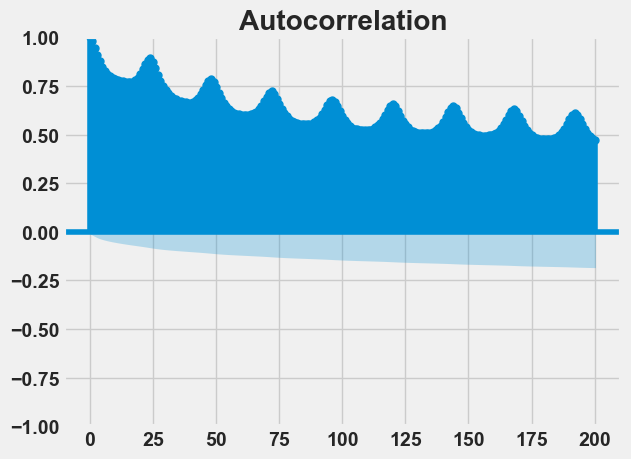

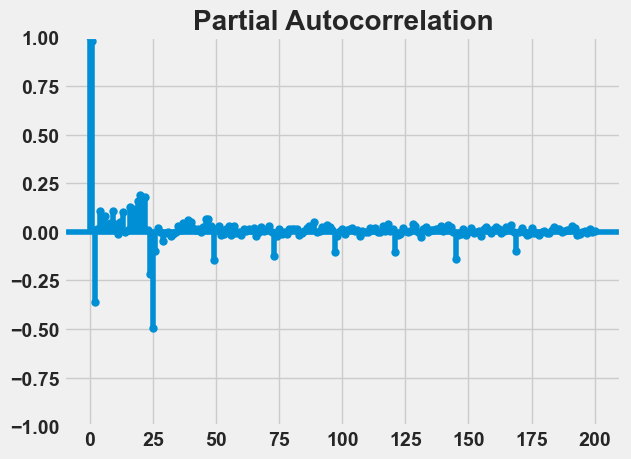

In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(df['Price(MWhr)'].dropna(), lags=200)
plt.show()

plot_pacf(df["Price(MWhr)"].dropna(), lags=200)
plt.show()

In [13]:
#Plot the price data to see it's properties over time
#df["Price(MWhr)"].plot(figsize=(12,5))

#Run a Dickey-Fuller Test to check for stationarity
from statsmodels.tsa.stattools import adfuller
#We can reject the null hypothesis that there is 

def dickey_fuller_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Used Lag:", result[2])
    print("Number of Observations Used:", result[3])
    print("Critical Values:", result[4])
    print("Maximized Likelihood:", result[5])
    print()

#for column in df.columns:
    #print(f"Testing {column}:")
    #dickey_fuller_test(df[column])

print(f"Testing Price(MWhr):")
dickey_fuller_test(df["Price(MWhr)"])



Testing Price(MWhr):
ADF Statistic: -6.097376034834153
p-value: 1.0024986455493865e-07
Used Lag: 44
Number of Observations Used: 17447
Critical Values: {'1%': -3.4307248645827237, '5%': -2.8617056756353163, '10%': -2.5668581848456404}
Maximized Likelihood: 110647.96313328607



As a warning, the pmdarima library is not compatible with the more recent versions of numpy. Therefore, if you ever want to reproduce what I have here or use pmdarima concurrently with numpy in general, you'll need to downgrade numpy via entering the following line in the terminal: python -m pip install "numpy<2"

In [ ]:
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings("ignore")

#Automatic hyperparameter selection for the ARIMA model
arima_model = auto_arima(y_train, trace = True, supress_warnings = True, seasonal= False)

arima_model.summary()
#Best model:  ARIMA(5,1,1)(0,0,0)[0] 

# Forecast the test set
forecast, conf_int = arima_model.predict(n_periods=len(y_test), return_conf_int=True)

# Evaluate the model
rmse = np.sqrt(root_mean_squared_error(y_test, forecast))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast', color='red')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
plt.legend()
plt.show()

RMSE: 4.621485340774709


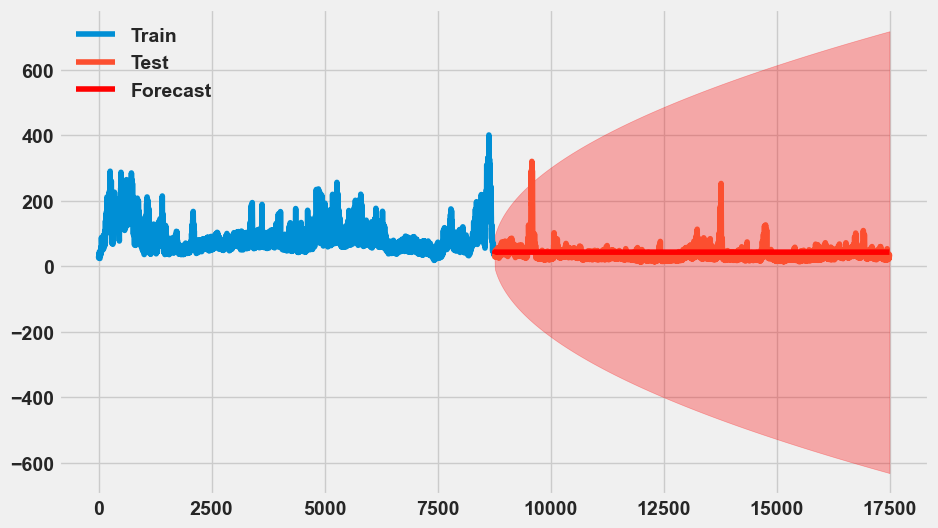

In [20]:
arima_model.summary()

# Forecast the test set
forecast, conf_int = arima_model.predict(n_periods=len(y_test), return_conf_int=True)

# Evaluate the model
rmse = np.sqrt(root_mean_squared_error(y_test, forecast))
print(f'RMSE: {rmse}')

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forecast, label='Forecast', color='red')
plt.fill_between(y_test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.3)
plt.legend()
plt.show()

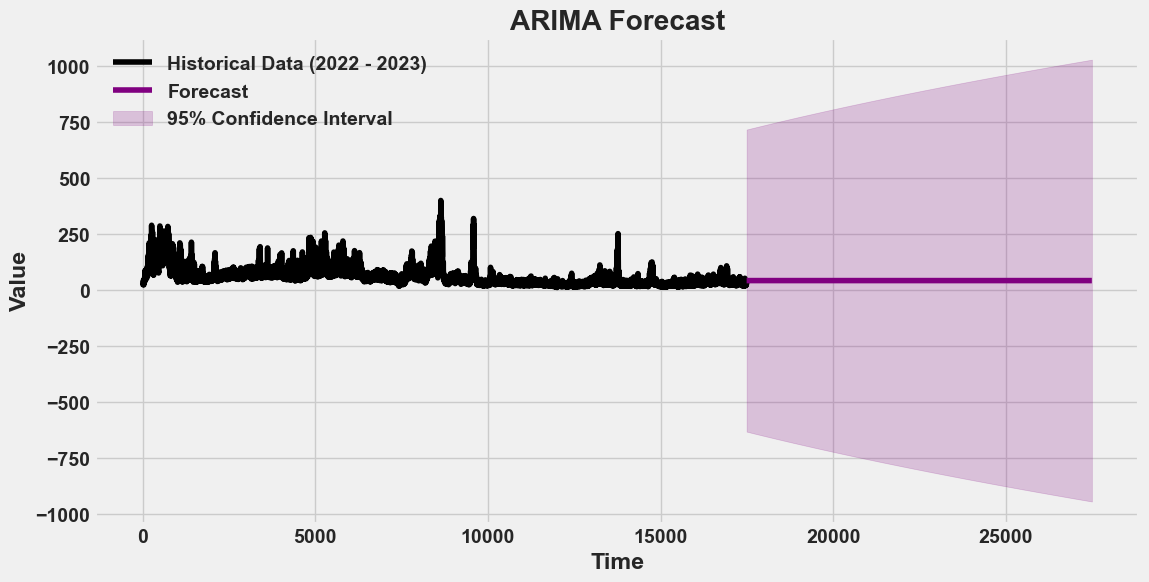

In [16]:
# Generate forecast 
n_periods = len(y_test) + 10000  
forecast, conf_int = arima_model.predict(n_periods=n_periods, return_conf_int=True)

# Time index for forecast
forecast_index = range(len(y_train), len(y_train) + n_periods)

# Plot historical data
plt.figure(figsize=(12, 6))
plt.plot(df["Price(MWhr)"], label='Historical Data (2022 - 2023)', color='black')

# Plot forecast (excluding testing period)
plt.plot(forecast_index[len(y_test):], forecast[len(y_test):], label='Forecast', color='purple')

# Plot confidence intervals (excluding testing period)
plt.fill_between(forecast_index[len(y_test):], 
                 conf_int[len(y_test):, 0], 
                 conf_int[len(y_test):, 1], 
                 color='purple', 
                 alpha=0.2, 
                 label='95% Confidence Interval')

plt.title('ARIMA Forecast')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()